In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn 

from tqdm import tqdm

2023-05-04 13:39:39.785246: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 13:39:40.303822: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 13:39:40.377747: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-04 13:39:40.377772: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [2]:
data_imgs = np.load('kkanj-imgs.npz')
data_labels = np.load('kkanji-labels.npz')

imgs = data_imgs['arr_0']
labels = data_labels['arr_0']

def kanji(kaniUnicode):
    return chr(int(kaniUnicode[2:], 16))

X = imgs[:14000]
Z = labels[:14000]


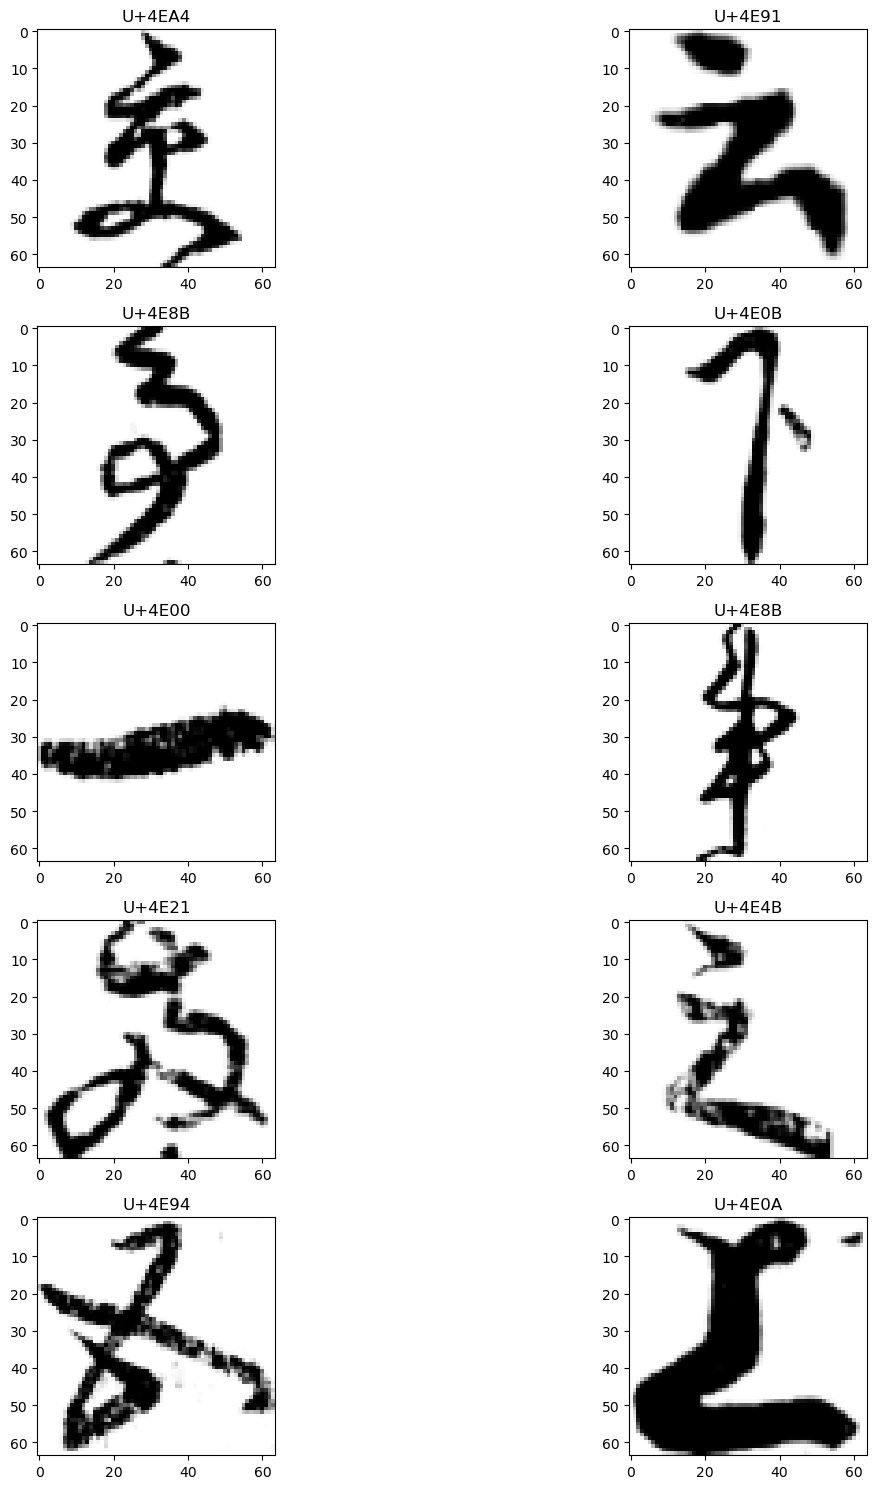

In [3]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap='Greys')
        ax[i,j].set_title(Z[l])
        
        
plt.tight_layout()

In [4]:
len(np.unique(Z))

79

In [5]:
le=LabelEncoder()


Y=le.fit_transform(Z)


Y=to_categorical(Y,len(np.unique(Z)))


X=np.array(X)


X=X/255


In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [7]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding= 'Same', activation='relu', input_shape = (64,64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(79, activation="softmax"))

2023-05-04 13:39:49.805859: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-04 13:39:49.807484: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-04 13:39:49.807750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6047883d479a): /proc/driver/nvidia/version does not exist
2023-05-04 13:39:49.810055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
batch_size=200
epochs=10

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.1)

In [9]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

#datagen.fit(x_train.reshape(10500, 64, 64, 1))

In [10]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        6240      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 96)         0

In [12]:
History = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
52/52 [==============================] - 13s 230ms/step - loss: 1.8959 - accuracy: 0.5803 - val_loss: 0.8650 - val_accuracy: 0.7894
Epoch 2/10
52/52 [==============================] - 11s 209ms/step - loss: 0.6456 - accuracy: 0.8439 - val_loss: 0.4503 - val_accuracy: 0.8860
Epoch 3/10
52/52 [==============================] - 9s 175ms/step - loss: 0.3496 - accuracy: 0.9119 - val_loss: 0.3094 - val_accuracy: 0.9229
Epoch 4/10
52/52 [==============================] - 9s 168ms/step - loss: 0.2149 - accuracy: 0.9429 - val_loss: 0.2519 - val_accuracy: 0.9309
Epoch 5/10
52/52 [==============================] - 9s 172ms/step - loss: 0.1432 - accuracy: 0.9605 - val_loss: 0.2390 - val_accuracy: 0.9386
Epoch 6/10
52/52 [==============================] - 9s 173ms/step - loss: 0.0948 - accuracy: 0.9731 - val_loss: 0.2135 - val_accuracy: 0.9460
Epoch 7/10
52/52 [==============================] - 9s 172ms/step - loss: 0.0594 - accuracy: 0.9831 - val_loss: 0.2331 - val_accuracy: 0.9489
Epoc

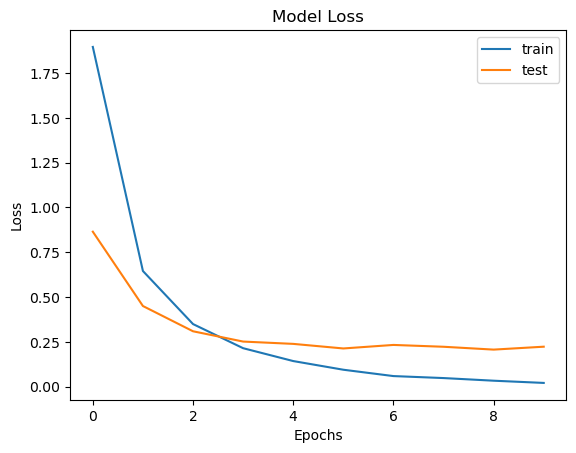

In [13]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()